In [ ]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import requests

In [ ]:
api_url = 'https://archive-api.open-meteo.com/v1/archive?latitude=43.7001&longitude=-79.4163&start_date=2013-01-01&end_date=2023-07-01&hourly=temperature_2m,relativehumidity_2m,dewpoint_2m,precipitation,weathercode,cloudcover,windspeed_10m,soil_moisture_0_to_7cm'

response = requests.get(api_url)

weather_data = response.json()

hourly_data = weather_data['hourly']

# Create an empty DataFrame to store the flattened data
weather_df = pd.DataFrame()

# Add each feature to the DataFrame as a new column
for feature, values in hourly_data.items():
    weather_df[feature] = values

# Convert time column to datetime object
weather_df["time"] = pd.to_datetime(weather_df["time"])

# Set the "time" column as the index
weather_df.set_index("time", inplace=True)


weather_df

,temperature_2m,relativehumidity_2m,dewpoint_2m,precipitation,weathercode,cloudcover,windspeed_10m,soil_moisture_0_to_7cm
time,,,,,,,,
2013-01-01 00:00:00,0.3,81,-2.6,0.0,3,100,18.8,0.445
2013-01-01 01:00:00,0.3,83,-2.3,0.0,71,100,16.9,0.444
2013-01-01 02:00:00,0.2,85,-2.1,0.0,71,100,16.2,0.444
2013-01-01 03:00:00,-0.1,81,-3.0,0.0,2,78,15.4,0.444
2013-01-01 04:00:00,-0.6,74,-4.8,0.0,2,66,16.2,0.444
...,...,...,...,...,...,...,...,...
2023-07-01 19:00:00,24.5,82,21.1,4.1,63,64,6.0,0.404
2023-07-01 20:00:00,24.1,82,20.8,0.0,2,59,2.3,0.415
2023-07-01 21:00:00,24.7,78,20.7,0.0,1,50,4.4,0.414


In [ ]:
# Reorder columns so that 'precipitation' is the first column
cols = list(weather_df.columns)
cols.insert(0, cols.pop(cols.index('precipitation')))
weather_df = weather_df.loc[:, cols]

In [ ]:
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np) - window_size):
    row = df_as_np[i:i+window_size]
    X.append(row)
    label = df_as_np[i+window_size, 0]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
window_size = 5
X, y = df_to_X_y(weather_df)

num_features = weather_df.shape[1]  # Number of features

X.shape, y.shape


((92011, 5, 8), (92011,))

In [ ]:
from sklearn.model_selection import train_test_split

# First split the data into 70% training and 30% temporary
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Then split the 30% temporary set into halves to create the validation and testing set
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [ ]:
model1 = Sequential()
model1.add(InputLayer((window_size, num_features)))  # Modify the input shape to match the number of features
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                18688     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 19,217
Trainable params: 19,217
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Only save the best model (lowest validation loss)
cp = ModelCheckpoint('model1/', save_best_only=True)


model1.compile(loss=MeanSquaredError(),
               optimizer=Adam(learning_rate=0.0001),
               metrics=[RootMeanSquaredError()])

In [ ]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp])

Epoch 1/10
2008/2013 [============================>.] - ETA: 0s - loss: 0.0968 - root_mean_squared_error: 0.3111

2013/2013 [==============================] - 37s 15ms/step - loss: 0.0966 - root_mean_squared_error: 0.3108 - val_loss: 0.0904 - val_root_mean_squared_error: 0.3006
Epoch 2/10
2010/2013 [============================>.] - ETA: 0s - loss: 0.0847 - root_mean_squared_error: 0.2911

2013/2013 [==============================] - 21s 11ms/step - loss: 0.0847 - root_mean_squared_error: 0.2910 - val_loss: 0.0835 - val_root_mean_squared_error: 0.2890
Epoch 3/10
2011/2013 [============================>.] - ETA: 0s - loss: 0.0790 - root_mean_squared_error: 0.2811

2013/2013 [==============================] - 19s 10ms/step - loss: 0.0790 - root_mean_squared_error: 0.2810 - val_loss: 0.0774 - val_root_mean_squared_error: 0.2782
Epoch 4/10
2012/2013 [============================>.] - ETA: 0s - loss: 0.0750 - root_mean_squared_error: 0.2738

2013/2013 [==============================] - 19s 10ms/step - loss: 0.0750 - root_mean_squared_error: 0.2738 - val_loss: 0.0733 - val_root_mean_squared_error: 0.2706
Epoch 5/10
2013/2013 [==============================] - ETA: 0s - loss: 0.0719 - root_mean_squared_error: 0.2682

2013/2013 [==============================] - 19s 10ms/step - loss: 0.0719 - root_mean_squared_error: 0.2682 - val_loss: 0.0709 - val_root_mean_squared_error: 0.2663
Epoch 6/10
2009/2013 [============================>.] - ETA: 0s - loss: 0.0700 - root_mean_squared_error: 0.2647

2013/2013 [==============================] - 19s 9ms/step - loss: 0.0699 - root_mean_squared_error: 0.2644 - val_loss: 0.0690 - val_root_mean_squared_error: 0.2626
Epoch 7/10
2013/2013 [==============================] - ETA: 0s - loss: 0.0683 - root_mean_squared_error: 0.2614

2013/2013 [==============================] - 20s 10ms/step - loss: 0.0683 - root_mean_squared_error: 0.2614 - val_loss: 0.0670 - val_root_mean_squared_error: 0.2588
Epoch 8/10
2006/2013 [============================>.] - ETA: 0s - loss: 0.0671 - root_mean_squared_error: 0.2590

2013/2013 [==============================] - 19s 10ms/step - loss: 0.0670 - root_mean_squared_error: 0.2589 - val_loss: 0.0670 - val_root_mean_squared_error: 0.2588
Epoch 9/10
2009/2013 [============================>.] - ETA: 0s - loss: 0.0660 - root_mean_squared_error: 0.2568

2013/2013 [==============================] - 20s 10ms/step - loss: 0.0660 - root_mean_squared_error: 0.2569 - val_loss: 0.0649 - val_root_mean_squared_error: 0.2548
Epoch 10/10
2013/2013 [==============================] - 14s 7ms/step - loss: 0.0653 - root_mean_squared_error: 0.2555 - val_loss: 0.0657 - val_root_mean_squared_error: 0.2563


In [ ]:
from tensorflow.keras.models import load_model

model1 = load_model('model1/')

In [ ]:
train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
train_results

2013/2013 [==============================] - 5s 2ms/step


,Train Predictions,Actuals
0,1.041530,0.4
1,0.001290,0.0
2,0.024148,0.0
3,0.033936,0.0
4,0.017287,0.0
...,...,...
64402,-0.001654,0.0
64403,-0.001689,0.0
64404,0.009436,0.0
64405,0.041960,0.0


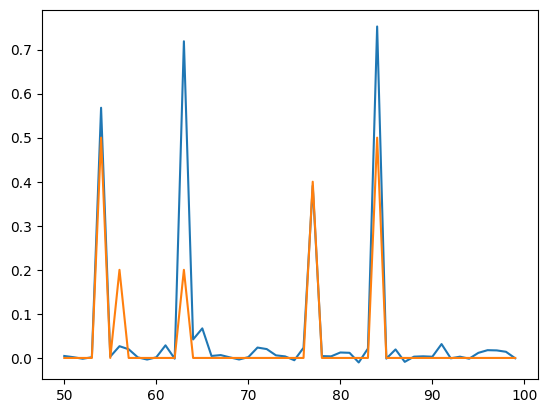

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])

In [ ]:
val_predictions = model1.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val})
val_results

432/432 [==============================] - 1s 3ms/step


,Val Predictions,Actuals
0,0.013367,0.0
1,0.180222,0.1
2,0.015573,0.2
3,0.186857,0.0
4,1.226416,0.1
...,...,...
13797,0.001938,0.0
13798,0.032000,0.0
13799,0.018154,0.0
13800,0.000459,0.0


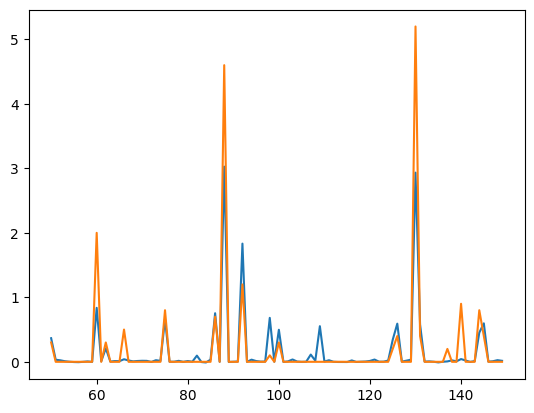

In [ ]:
plt.plot(val_results['Val Predictions'][50:150])
plt.plot(val_results['Actuals'][50:150])

In [ ]:
def predict_next_hour():

    # Create an empty DataFrame to store the flattened data
    latest_weather_df = pd.DataFrame()

    # Add each feature to the DataFrame as a new column
    for feature, values in hourly_data.items():
        latest_weather_df[feature] = values[-window_size:] # Taking only the latest 'window_size' entries

    # Reorder columns to match the order used for training
    cols = list(weather_df.columns)
    cols.insert(0, cols.pop(cols.index('precipitation')))
    latest_weather_df = latest_weather_df.loc[:, cols]

    # Convert DataFrame to numpy array and reshape it to match the input shape that the model expects
    latest_data = latest_weather_df.to_numpy().reshape(1, window_size, num_features)

    # Use the trained model to make a prediction
    prediction = model1.predict(latest_data)
    print(f'The predicted precipitation for the next hour is: {prediction[0][0]} mm')


predict_next_hour()



1/1 [==============================] - 0s 26ms/step
The predicted precipitation for the next hour is: 0.027509033679962158 mm
